In [18]:
import datetime
import json
import boto3
import io
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
#import seaborn as sns
plt.style.use('ggplot')

In [19]:
pickle_file = '../btc-autotrader/lib/data/log/2019-04-25T07:59:58.178038.pickle'

In [20]:
df = pd.read_pickle(pickle_file)

In [21]:
df.head()

,datetime,cash,cash_orig,btc_in_possession,btc_current_price,position,rate_of_change,total_value,acceleration,bid_high,ask_low,mid_price,bought_price,sold_price,ask_price,target_profit,size
0,2019-04-25 08:00:03.848380,42539.0,0,0.008679,611500.0,0,1.268062,0,None,611500.0,611787.0,611643.0,0,0,0,100,0
0,2019-04-25 08:00:08.865314,42539.0,0,0.008679,611500.0,0,1.269854,0,0.000177887,611500.0,611787.0,611643.0,0,0,0,100,0
0,2019-04-25 08:00:13.879647,42539.0,0,0.008679,611787.0,0,1.269854,0,0.000177887,611500.0,611785.0,611642.0,0,0,0,100,0
0,2019-04-25 08:00:18.895399,36421.0,0,0.018667,611785.0,2,1.289793,0,0.00397114,611500.0,611785.0,611642.0,611785,0,611885,100,0
0,2019-04-25 08:00:23.920676,36421.0,0,0.018667,611785.0,3,1.308728,0,0.00376852,611500.0,611784.0,611642.0,611785,0,611885,100,0


In [22]:
df['spread'] = df.ask_low - df.bid_high

In [23]:
df['spread_pct_change'] = df.spread.pct_change()

In [24]:
df.loc[df.rate_of_change >= 0, 'rate_of_change_positive'] = 1
df.loc[df.rate_of_change < 0, 'rate_of_change_positive'] = -1
df.loc[df.rate_of_change >= 5, 'rate_of_change_positive'] = 2
df.loc[df.rate_of_change < -5, 'rate_of_change_positive'] = -2

In [25]:
df['btc_current_price_normalized'] = (df.btc_current_price - df.btc_current_price.mean()) / df.btc_current_price.std()


In [26]:
df['returns'] = np.log(df['btc_current_price']/df['btc_current_price'].shift(1))

In [27]:
df['strategy'] = df['rate_of_change_positive'].shift(1) * df['returns']

In [28]:
df.tail()

,datetime,cash,cash_orig,btc_in_possession,btc_current_price,position,rate_of_change,total_value,acceleration,bid_high,...,sold_price,ask_price,target_profit,size,spread,spread_pct_change,rate_of_change_positive,btc_current_price_normalized,returns,strategy
0,2019-04-25 08:25:31.052380,42525.0,0,0.008631,609015.0,0,-1.634700,0,-0.00420474,609015.0,...,610501,612002,4,0,786.0,0.001274,-1.0,-1.887727,-0.000003,0.000003
0,2019-04-25 08:25:36.076351,42525.0,0,0.008631,609015.0,0,-1.659491,0,-0.0049349,609017.0,...,610501,612002,4,0,784.0,-0.002545,-1.0,-1.887727,0.000000,-0.000000
0,2019-04-25 08:25:41.102251,42525.0,0,0.008631,609015.0,0,-1.659491,0,0,609017.0,...,610501,612002,4,0,773.0,-0.014031,-1.0,-1.887727,0.000000,-0.000000
0,2019-04-25 08:25:46.127681,42525.0,0,0.008631,609015.0,0,-1.659491,0,0,609017.0,...,610501,612002,4,0,769.0,-0.005175,-1.0,-1.887727,0.000000,-0.000000
0,2019-04-25 08:25:51.150739,42525.0,0,0.008631,609015.0,0,-1.659491,0,0,609020.0,...,610501,612002,4,0,763.0,-0.007802,-1.0,-1.887727,0.000000,-0.000000


In [29]:
np.exp(df[['returns', 'strategy']].sum())

returns     0.995936
strategy    1.002790
dtype: float64

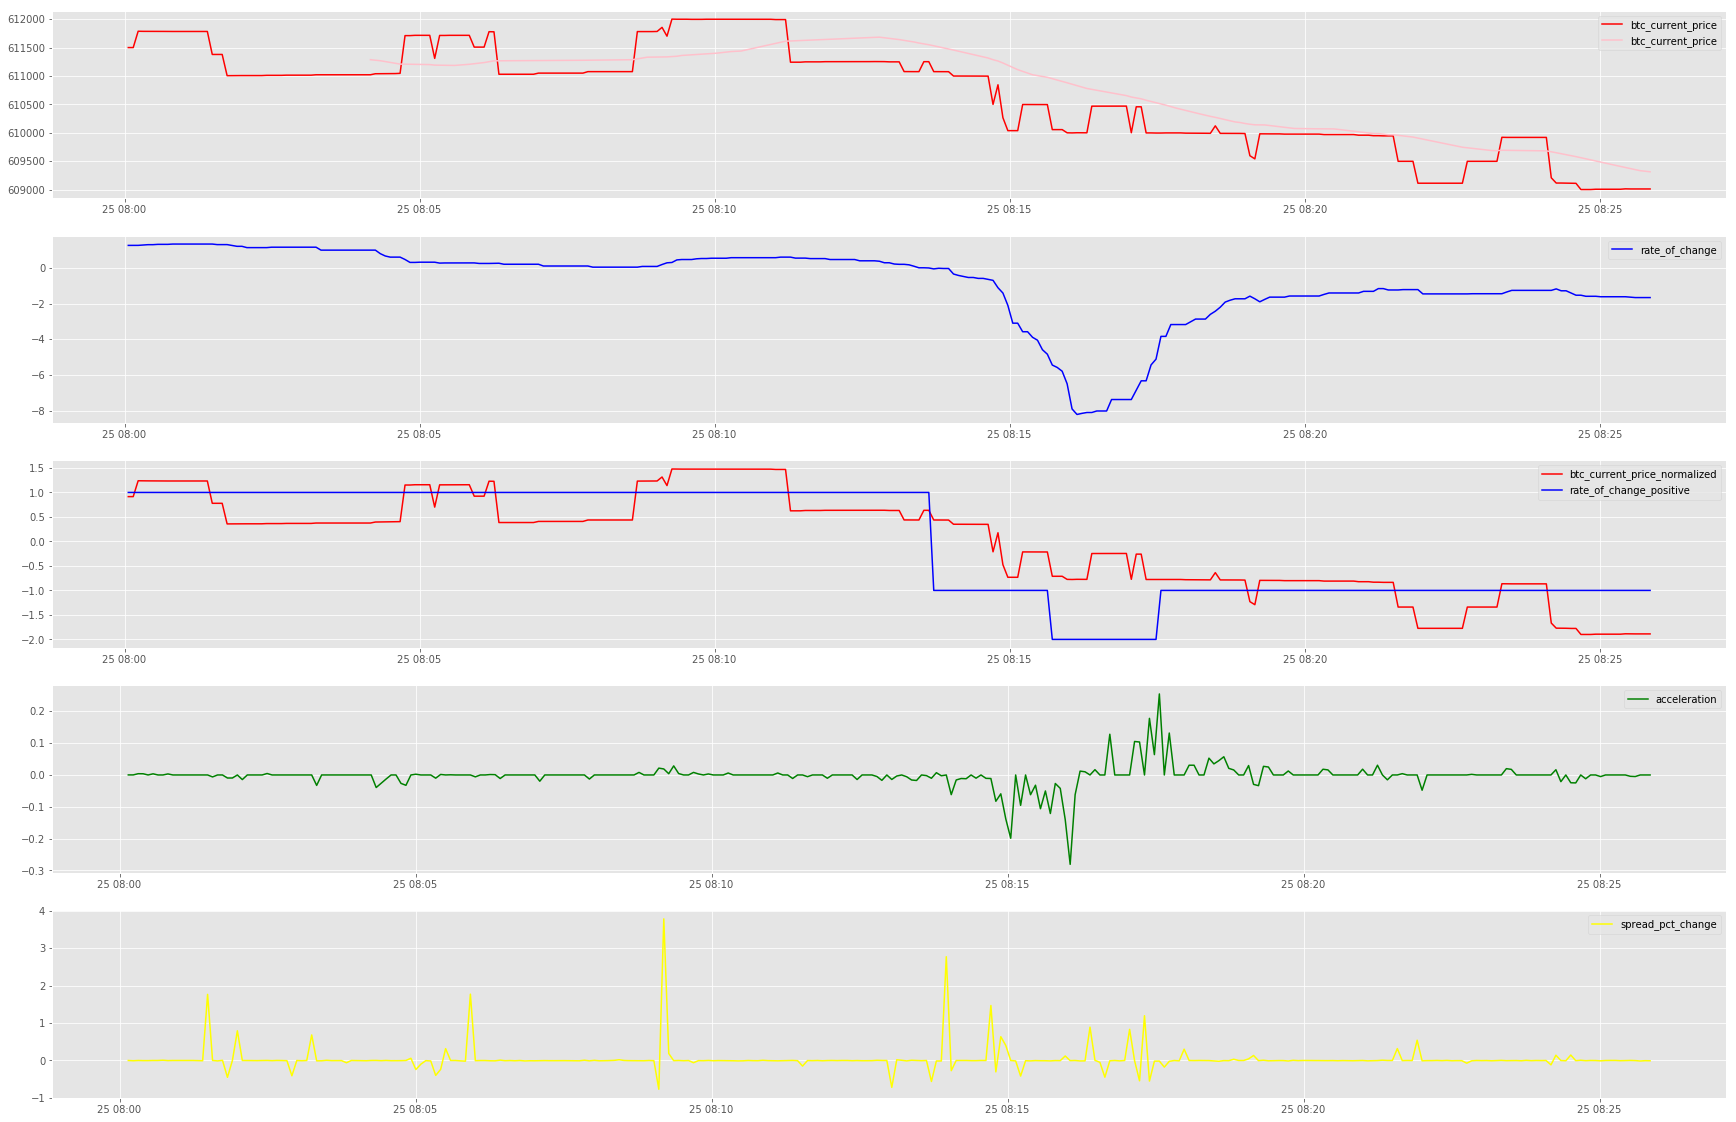

In [30]:
num = 5
fig, axes = plt.subplots(nrows=num, ncols=1, figsize=(30, 20), sharex=True)
plt.subplot(num,1,1)
plt.plot(df.datetime, df.btc_current_price, color='r')
plt.plot(df.datetime, df.btc_current_price.rolling(50).mean(), color='pink')
plt.legend()
#ax1.plot(df.datetime, df.ask_low, color='cyan', linestyle='--')
#ax1.plot(df.datetime, df.bid_high, color='magenta', linestyle='--')
#ax2.plot(df.datetime, df.spread, color='gray')
#ax1.scatter(df.datetime, df.bid_price, color='black')
plt.subplot(num,1,2)
plt.plot(df.datetime, df.rate_of_change, color='b')
plt.legend()
plt.subplot(num,1,3)
plt.plot(df.datetime, df.btc_current_price_normalized, color='r')
plt.plot(df.datetime, df.rate_of_change_positive, color='b')
plt.legend()
plt.subplot(num,1,4)
plt.plot(df.datetime, df.acceleration, color='g')
#plt.yscale('log')
plt.legend()
plt.subplot(num,1,5)
plt.plot(df.datetime, df.spread_pct_change, color='yellow')
plt.legend()
#plt.plot(df.datetime, df.spread_pct_change())
plt.show()

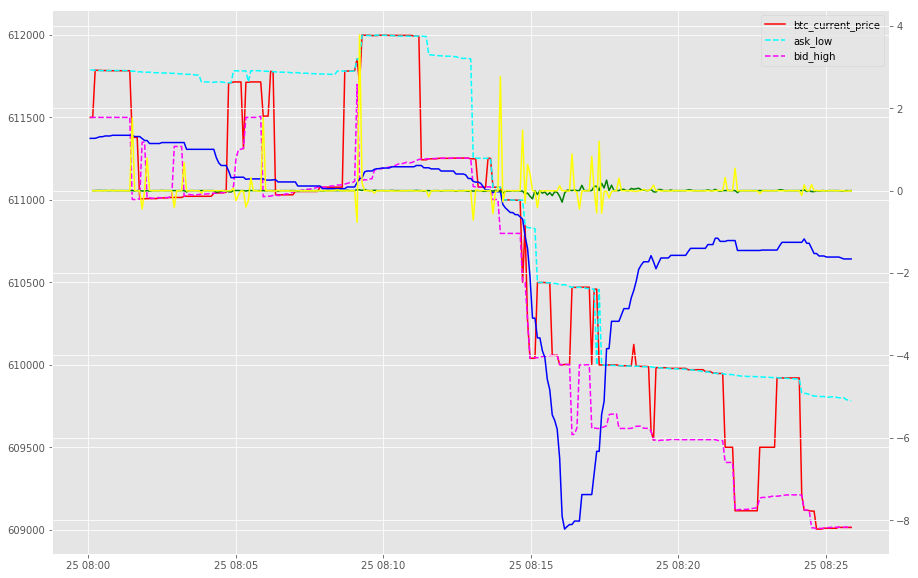

In [31]:
fig, ax1 = plt.subplots(figsize=(15,10))
ax2 = ax1.twinx()
ax1.plot(df.datetime, df.btc_current_price, color='r')
ax1.plot(df.datetime, df.ask_low, color='cyan', linestyle='--')
ax1.plot(df.datetime, df.bid_high, color='magenta', linestyle='--')
ax1.legend()
#ax2.plot(df.datetime, df.spread, color='gray')
#ax1.scatter(df.datetime, df.bid_price, color='black')
ax2.plot(df.datetime, df.rate_of_change, color='b')
ax2.plot(df.datetime, df.acceleration, color='g')
ax2.plot(df.datetime, df.spread_pct_change, color='yellow')
#ax2.legend()
plt.show()

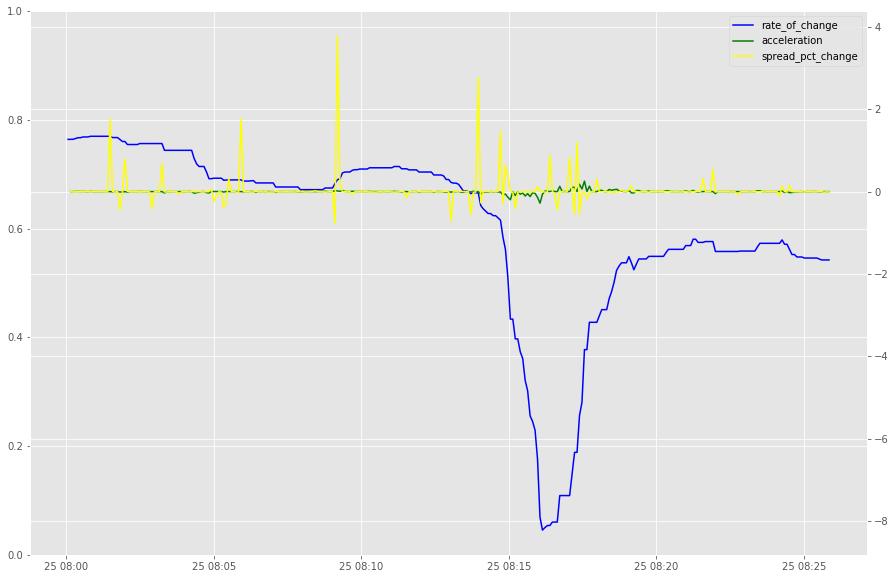

In [32]:
fig, ax1 = plt.subplots(figsize=(15,10))
ax2 = ax1.twinx()
#ax1.plot(df.datetime, df.btc_current_price, color='r')
#ax2.plot(df.datetime, df.spread, color='gray')
#ax1.scatter(df.datetime, df.bid_price, color='black')
ax2.plot(df.datetime, df.rate_of_change, color='b')
ax2.plot(df.datetime, df.acceleration, color='g')
ax2.plot(df.datetime, df.spread_pct_change, color='yellow')
ax2.legend()
plt.show()

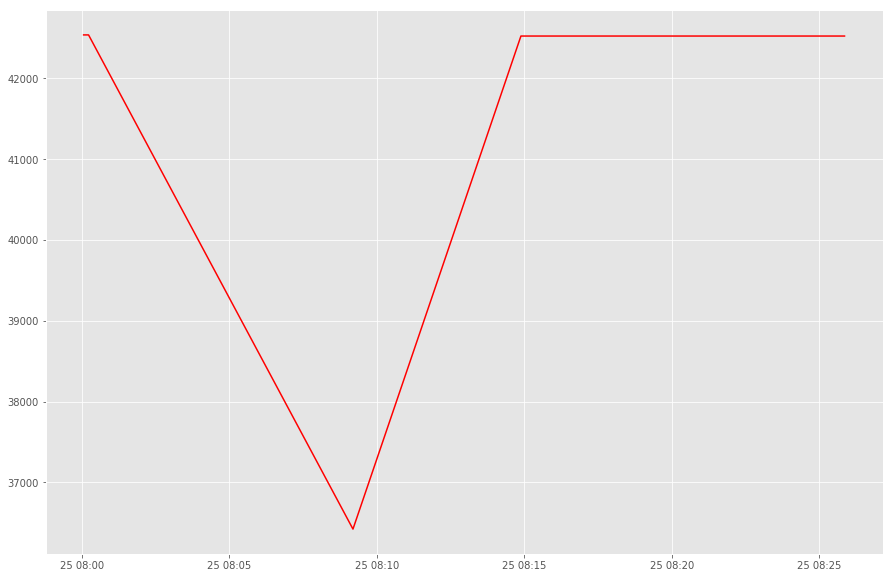

In [33]:
df_cash = df[df.position == 0]
fig, ax1 = plt.subplots(figsize=(15,10))
ax1.plot(df_cash.datetime, df_cash.cash, color='r')

In [34]:
df

,datetime,cash,cash_orig,btc_in_possession,btc_current_price,position,rate_of_change,total_value,acceleration,bid_high,...,sold_price,ask_price,target_profit,size,spread,spread_pct_change,rate_of_change_positive,btc_current_price_normalized,returns,strategy
0,2019-04-25 08:00:03.848380,42539.0,0,0.008679,611500.0,0,1.268062,0,None,611500.0,...,0,0,100,0,287.0,NaN,1.0,0.914810,NaN,NaN
0,2019-04-25 08:00:08.865314,42539.0,0,0.008679,611500.0,0,1.269854,0,0.000177887,611500.0,...,0,0,100,0,287.0,0.000000,1.0,0.914810,0.000000,0.000000
0,2019-04-25 08:00:13.879647,42539.0,0,0.008679,611787.0,0,1.269854,0,0.000177887,611500.0,...,0,0,100,0,285.0,-0.006969,1.0,1.238483,0.000469,0.000469
0,2019-04-25 08:00:18.895399,36421.0,0,0.018667,611785.0,2,1.289793,0,0.00397114,611500.0,...,0,611885,100,0,285.0,0.000000,1.0,1.236227,-0.000003,-0.000003
0,2019-04-25 08:00:23.920676,36421.0,0,0.018667,611785.0,3,1.308728,0,0.00376852,611500.0,...,0,611885,100,0,284.0,-0.003509,1.0,1.236227,0.000000,0.000000
0,2019-04-25 08:00:28.943152,36421.0,0,0.008655,611784.0,3,1.308728,0,0,611500.0,...,0,611886,101,0,283.0,-0.003521,1.0,1.235099,-0.000002,-0.000002
0,2019-04-25 08:00:33.968807,36421.0,0,0.018667,611784.0,3,1.326805,0,0.00359715,611500.0,...,0,611887,102,0,283.0,0.000000,1.0,1.235099,0.000000,0.000000
0,2019-04-25 08:00:38.992168,36421.0,0,0.008655,611784.0,3,1.326805,0,0,611500.0,...,0,611888,103,0,283.0,0.000000,1.0,1.235099,0.000000,0.000000
0,2019-04-25 08:00:44.017061,36421.0,0,0.018667,611783.0,3,1.326805,0,0,611500.0,...,0,611889,104,0,285.0,0.007067,1.0,1.233972,-0.000002,-0.000002
0,2019-04-25 08:00:49.040997,36421.0,0,0.018667,611783.0,3,1.343203,0,0.00326282,611500.0,...,0,611890,105,0,284.0,-0.003509,1.0,1.233972,0.000000,0.000000
